In [87]:
# @title install package
!pip install -q ktrain

In [ ]:
# @title import packages
# !pip install ucimlrepo
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification
from tensorflow import keras
import ktrain
from ktrain import text
import torch
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification

## **Convert the train and test as downloaded from UCL**

In [51]:
train_set = pd.read_csv("drugsComTrain_raw.tsv", sep="\t")
test_set = pd.read_csv("drugsComTest_raw.tsv", sep="\t")
train_set['rating'] = train_set['rating'].astype(int)
test_set['rating'] = test_set['rating'].astype(int)

## **Data analysing**

In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Unnamed: 0   161297 non-null  int64 
 1   drugName     161297 non-null  object
 2   condition    160398 non-null  object
 3   review       161297 non-null  object
 4   rating       161297 non-null  int64 
 5   date         161297 non-null  object
 6   usefulCount  161297 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 8.6+ MB


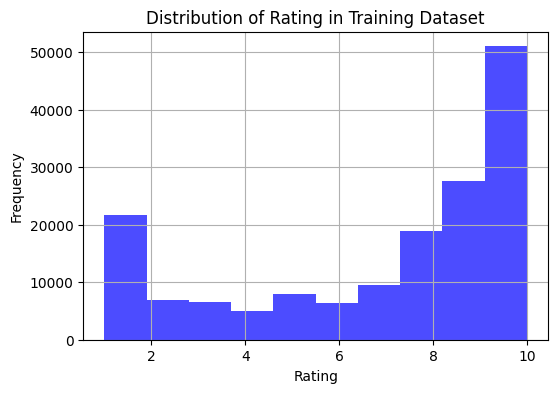

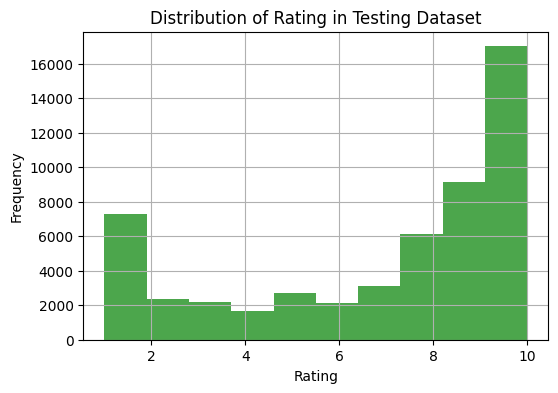

In [ ]:
# @title Classes distributaion
# check the raiting distribution both on the train and test
# Plotting the distribution of 'rating' feature in the training dataset
plt.figure(figsize=(6, 4))
plt.hist(train_set['rating'], bins=10, color='blue', alpha=0.7)
plt.title('Distribution of Rating in Training Dataset')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plotting the distribution of 'rating' feature in the testing dataset
plt.figure(figsize=(6, 4))
plt.hist(test_set['rating'], bins=10, color='green', alpha=0.7)
plt.title('Distribution of Rating in Testing Dataset')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
# @title Cinvert date column to years passed
# Drop the 'review' column
simple_X_train = train_set.drop(columns=['review'])

# Convert the 'date' column to datetime
simple_X_train['date'] = pd.to_datetime(simple_X_train['date'])

# Create a new column to represent the years passed from now
simple_X_train['years_passed'] = datetime.now().year - simple_X_train['date'].dt.year
simple_X_train.drop(columns=['date'], inplace=True)
# Rename the DataFrame as simple_X_train
simple_X_train.head()


,Unnamed: 0,drugName,condition,rating,usefulCount,years_passed
0,206461,Valsartan,Left Ventricular Dysfunction,9,27,12
1,95260,Guanfacine,ADHD,8,192,14
2,92703,Lybrel,Birth Control,5,17,15
3,138000,Ortho Evra,Birth Control,8,10,9
4,35696,Buprenorphine / naloxone,Opiate Dependence,9,37,8


In [ ]:
# Split the train set into features (X_train) and target variable (y_train)
simple_X_train1 = simple_X_train.drop(columns=['rating'])
simple_y_train1 = simple_X_train['rating']



## **Build simple logistic regression model without 'review' feature**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# Remove 'drugName' and 'condition' columns
simple_X_train1.drop(columns=['drugName', 'condition', 'Unnamed: 0'], inplace=True)

# Reset index for simple_X_train
# simple_X_train.reset_index(drop=True, inplace=True)

# # Reset index for y_train_simple
# y_train_simple.reset_index(drop=True, inplace=True)

# Split the data into train and validation sets
X_train_simple, X_val_simple, y_train_simple, y_val_simple = train_test_split(simple_X_train1, simple_y_train1, test_size=0.2, random_state=42)

# Initialize the model
model_simple = RandomForestClassifier(random_state=42)

# Train the model on the training data
model_simple.fit(X_train_simple, y_train_simple)

# Make predictions on the validation data
y_pred_simple = model_simple.predict(X_val_simple)

# Calculate accuracy and F1-score
accuracy_simple = accuracy_score(y_val_simple, y_pred_simple)
f1_score_simple = f1_score(y_val_simple, y_pred_simple, average='weighted')

print("Accuracy:", accuracy_simple)
print("F1 Score:", f1_score_simple)

Accuracy: 0.32107873527588343
F1 Score: 0.21800413570571026


## **'review' feature analysis before build BERT**

<Axes: >

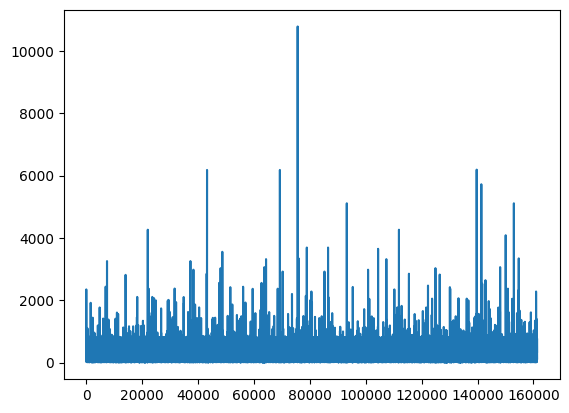

In [ ]:
train_set['review'].str.len().plot()

In [ ]:
# most of the the reviews are lower than 2000 so lets filter the train data
train_set=train_set[train_set['review'].str.len()<=2000]

<Axes: >

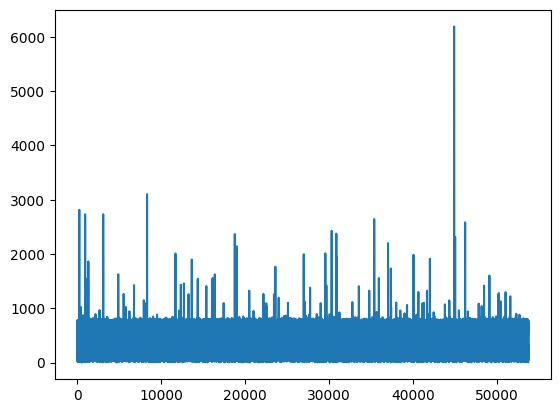

In [ ]:
# plot the review featur distributaion in the test set
test_set['review'].str.len().plot()

In [ ]:
# most of the the reviews are lower than 2000 so lets filter the test data
test_set=test_set[test_set['review'].str.len()<=2000]

In [ ]:
# @title Example of high rating vs low rating
# Filter high-rating reviews (rating >= 10)
high_rating_reviews = train_set[train_set['rating'] >= 10].head(1)

# Filter low-rating reviews (rating <= 2)
low_rating_reviews = train_set[train_set['rating'] <= 2].head(1)

# Concatenate both high-rating and low-rating reviews
examples = pd.concat([high_rating_reviews, low_rating_reviews])

# Print the examples
examples[['drugName', 'condition', 'review', 'rating']]

,drugName,condition,review,rating
7,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10
5,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2


## **Train and validation split**:
because the lables are imbalance, I split the data set in a stratified fashion, using this as the class labels.


In [52]:
# substruct the class rating by one
train_set['rating'] -= 1
test_set['rating'] -= 1

In [53]:
bert_train_set = train_set[['review', 'rating']]
bert_test_set = test_set[['review', 'rating']]

In [54]:
# @title split the train into validation and train
X_train, X_val, y_train, y_val = train_test_split(bert_train_set.index.values,
                                                  bert_train_set['rating'].values,
                                                  test_size=0.15,
                                                  random_state=42,
                                                  stratify=bert_train_set['rating'].values)

In [88]:
# @title splitted data
bert_train_set['data_type'] = ['not_set']*bert_train_set.shape[0]
bert_train_set.loc[X_train, 'data_type'] = 'train'
bert_train_set.loc[X_val, 'data_type'] = 'val'

bert_train_set.groupby(['rating',  'data_type']).count()

<ipython-input-88-9757f5b09e66>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bert_train_set['data_type'] = ['not_set']*bert_train_set.shape[0]


review
rating data_type        
0      train       18376
       val          3243
1      train        5891
       val          1040
2      train        5536
       val           977
3      train        4260
       val           752
4      train        6811
       val          1202
5      train        5392
       val           951
6      train        8038
       val          1418
7      train       16056
       val          2834
8      train       23401
       val          4130
9      train       43341
       val          7648

## **BertTokenizer and Encoding the Data**

In [68]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)

In [69]:
encoded_data_train = tokenizer.batch_encode_plus(
    bert_train_set[bert_train_set.data_type=='train']['review'].values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

In [70]:
encoded_data_val = tokenizer.batch_encode_plus(
    bert_train_set[bert_train_set.data_type=='val']['review'].values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

In [71]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(bert_train_set[bert_train_set.data_type=='train']['rating'].values)

In [72]:
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(bert_train_set[bert_train_set.data_type=='val']['rating'].values)

In [73]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [74]:
# @title Load pretraind BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=10,
                                                      output_attentions=False,
                                                      output_hidden_states=False,
                                                      from_tf=True)



## **Data Loaders**


In [76]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)
dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

## **Optimizer & Scheduler**

In [77]:
from transformers import AdamW, get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [78]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    num_classes = preds.shape[1]  # Get the number of classes from the shape of preds
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in range(num_classes):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label}')  # Print class index
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')




## **Training Loop**

In [79]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [80]:
# Check if GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using device:', device)

Using device: cuda


In [81]:
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids': batch[0].to(device),
          'attention_mask': batch[1].to(device),
          'labels': batch[2].to(device)}

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [82]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
import os
from google.colab import files
from google.colab import drive
# Define the folder path in your Google Drive
drive_folder_path = '/content/drive/My Drive'
for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids': batch[0].to(device),
          'attention_mask': batch[1].to(device),
          'labels': batch[2].to(device)}

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


        directory = os.path.join(drive_folder_path, 'data_volume')
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save model

    model_path = os.path.join(directory, f'finetuned_BERT_epoch_{epoch}.model')
    torch.save(model.state_dict(), model_path)
    # files.download(model_path)
    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

## **Continue training the DNN from with smeller learning rate and batch size**

In [ ]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


drive_folder_path = '/content/drive/My Drive'

# Load the model weights from epoch 2
model_path_epochx = os.path.join(drive_folder_path, 'data_volume/finetuned_BERT_epoch_7.model')
model.load_state_dict(torch.load(model_path_epochx))

# Define the new hyperparameters
new_learning_rate = 2e-5
new_batch_size = 16


# Update the optimizer and scheduler with new hyperparameters
optimizer = AdamW(model.parameters(), lr=new_learning_rate, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train)*(epochs-2))


for epoch in tqdm(range(10, 11)):

    model.train()
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:
        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids': batch[0].to(device),
          'attention_mask': batch[1].to(device),
          'labels': batch[2].to(device)}

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


        directory = os.path.join(drive_folder_path, 'data_volume')

    if not os.path.exists(directory):
        os.makedirs(directory)
    model_path = os.path.join(directory, f'finetuned_BERT_epoch_{epoch}.model')
    torch.save(model.state_dict(), model_path)

    tqdm.write(f'\nEpoch {epoch}')


# Unmount Google Drive
drive.flush_and_unmount()


## **Load models and compare accuracy and f1**

In [83]:
import os
from google.colab import drive
from sklearn.metrics import accuracy_score, f1_score
from tabulate import tabulate

# Mount Google Drive
drive.mount('/content/drive')


drive_folder_path = '/content/drive/My Drive'

num_epochs = 10

# Initialize lists to store evaluation results
results = []

# Iterate over each epoch
for epoch in range(1, num_epochs + 1):
    if epoch ==5:
      continue
    # Load the model weights for the current epoch
    model_path = os.path.join(drive_folder_path, f'data_volume/finetuned_BERT_epoch_{epoch}.model')
    model.load_state_dict(torch.load(model_path))

    # Evaluate the model on the validation set
    val_loss, predictions, true_vals = evaluate(dataloader_validation)

    # Calculate F1 score
    f1 = f1_score(true_vals, np.argmax(predictions, axis=1), average='weighted')

    # Calculate accuracy
    accuracy = accuracy_score(true_vals, np.argmax(predictions, axis=1))

    # Store epoch, validation loss, F1 score, and accuracy
    results.append((epoch, val_loss, f1, accuracy))
    headers=['Epoch', 'Validation Loss', 'F1 Score', 'Accuracy']

# Print results as a table
# Print results as a table with formatting
print(tabulate(results, headers=headers, tablefmt='fancy_grid', numalign='center', stralign='center'))




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
╒═════════╤═══════════════════╤════════════╤════════════╕
│  Epoch  │  Validation Loss  │  F1 Score  │  Accuracy  │
╞═════════╪═══════════════════╪════════════╪════════════╡
│    1    │      1.30143      │  0.443593  │  0.506055  │
├─────────┼───────────────────┼────────────┼────────────┤
│    2    │      1.20107      │  0.477667  │  0.53478   │
├─────────┼───────────────────┼────────────┼────────────┤
│    3    │      1.06572      │  0.56457   │  0.595288  │
├─────────┼───────────────────┼────────────┼────────────┤
│    4    │     0.917055      │  0.645548  │  0.66336   │
├─────────┼───────────────────┼────────────┼────────────┤
│    6    │      0.73586      │  0.737759  │  0.744865  │
├─────────┼───────────────────┼────────────┼────────────┤
│    7    │     0.590592      │  0.806642  │  0.810374  │
├─────────┼───────────────────┼────────────┼────────────┤
│

## **Load model and test it**

In [89]:
import os
from google.colab import drive
from transformers import BertForSequenceClassification

# Mount Google Drive
drive.mount('/content/drive')


drive_folder_path = '/content/drive/My Drive'

# Load the model from Google Drive
model_path = os.path.join(drive_folder_path, f'data_volume/finetuned_BERT_epoch_10.model')
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=10,
                                                      output_attentions=False,
                                                      output_hidden_states=False,
                                                      from_tf=True)

model.load_state_dict(torch.load(model_path))

# Move model to device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## **Tokenization to the test set**

In [90]:

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenize the test data
encoded_data_test = tokenizer.batch_encode_plus(
    bert_test_set['review'].values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

In [91]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, f1_score

# Prepare DataLoader for test set
input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(bert_test_set['rating'].values)

dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)
dataloader_test = DataLoader(dataset_test, sampler=SequentialSampler(dataset_test), batch_size=16)

# Set model to evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
predictions_test = []
true_labels_test = []

# Iterate over batches in the test DataLoader
for batch in dataloader_test:
    # Move batch to GPU if available
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from the DataLoader
    input_ids, attention_masks, labels = batch

    # Deactivate autograd
    with torch.no_grad():
        # Forward pass
        outputs = model(input_ids, attention_mask=attention_masks)

    # Get predicted labels
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    predictions_test.extend(np.argmax(logits, axis=1).flatten())

    # Get true labels
    true_labels_test.extend(labels.cpu().numpy())

# Calculate accuracy and F1 score on the test set
accuracy_test = accuracy_score(true_labels_test, predictions_test)
f1_score_test = f1_score(true_labels_test, predictions_test, average='weighted')

print(f"Accuracy on test set: {accuracy_test}")
print(f"F1 Score on test set: {f1_score_test}")

Accuracy on test set: 0.6406279061116691
F1 Score on test set: 0.6382534573506756



## **Part 2: 3 class classification**

---


## **preprocess for 3 class classification**




In [ ]:
def classify_rating(rating):
    if rating <= 4:
        return 0  # Class 0 for ratings <= 4
    elif rating < 7:
        return 1  # Class 1 for ratings between 4 and 7
    else:
        return 2  # Class 2 for ratings => 7

In [25]:
train_set = pd.read_csv("drugsComTrain_raw.tsv", sep="\t")
test_set = pd.read_csv("drugsComTest_raw.tsv", sep="\t")
train_set['rating'] = train_set['rating'].astype(int)
test_set['rating'] = test_set['rating'].astype(int)

In [26]:
# most of the the reviews are lower than 2000 so lets filter the train and test data
train_set=train_set[train_set['review'].str.len()<=2000]
test_set=test_set[test_set['review'].str.len()<=2000]

In [28]:
# Apply new classes to the train set
train_set['class'] = train_set['rating'].apply(classify_rating)

# Apply new classes to the test set
test_set['class'] = test_set['rating'].apply(classify_rating)


In [29]:
train_set.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,class
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,"May 20, 2012",27,2
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,"April 27, 2010",192,2
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,"December 14, 2009",17,1
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,"November 3, 2015",10,2
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,"November 27, 2016",37,2


In [30]:
# Filter high-rating reviews (rating >= 10)
high_rating_reviews = train_set[train_set['class'] >= 2].head(1)

# Filter low-rating reviews (rating <= 2)
low_rating_reviews = train_set[train_set['class'] <= 0].head(1)

# Concatenate both high-rating and low-rating reviews
examples = pd.concat([high_rating_reviews, low_rating_reviews])

# Print the examples
examples[['drugName', 'condition', 'review','rating', 'class']]

,drugName,condition,review,rating,class
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2
5,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,0


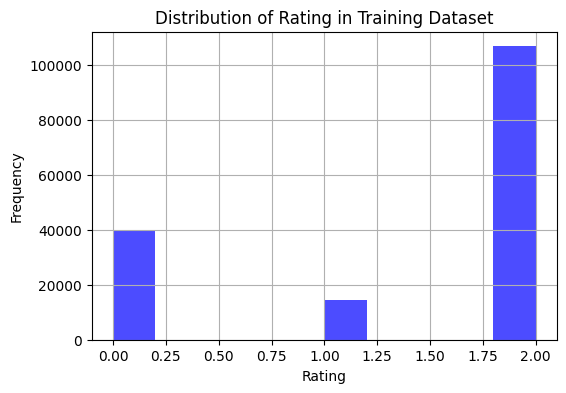

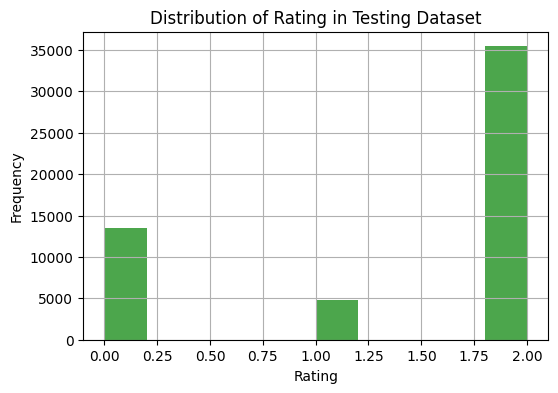

In [31]:
# @title Class distribution
plt.figure(figsize=(6, 4))
plt.hist(train_set['class'], bins=10, color='blue', alpha=0.7)
plt.title('Distribution of Rating in Training Dataset')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plotting the distribution of 'rating' feature in the testing dataset
plt.figure(figsize=(6, 4))
plt.hist(test_set['class'], bins=10, color='green', alpha=0.7)
plt.title('Distribution of Rating in Testing Dataset')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [32]:
bert_train_set = train_set[['review', 'class']]
bert_test_set = test_set[['review', 'class']]

In [33]:
X_train, X_val, y_train, y_val = train_test_split(bert_train_set.index.values,
                                                  bert_train_set['class'].values,
                                                  test_size=0.15,
                                                  random_state=42,
                                                  stratify=bert_train_set['class'].values)

In [34]:
# @title Splitted data
bert_train_set['data_type'] = ['not_set']*bert_train_set.shape[0]
bert_train_set.loc[X_train, 'data_type'] = 'train'
bert_train_set.loc[X_val, 'data_type'] = 'val'

bert_train_set.groupby(['class',  'data_type']).count()

<ipython-input-34-5d48df14e351>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bert_train_set['data_type'] = ['not_set']*bert_train_set.shape[0]


review
class data_type        
0     train       34043
      val          6008
1     train       12201
      val          2153
2     train       90802
      val         16024

## **BertTokenizer and Encoding the Data**

In [ ]:
from transformers import BertTokenizer

# Define the model identifier for BioBERT
model_identifier = 'dmis-lab/biobert-v1.1'

try:
    # Load the tokenizer for BioBERT
    tokenizer = BertTokenizer.from_pretrained(model_identifier, do_lower_case=True)
    print("BioBERT tokenizer loaded successfully!")
except Exception as e:
    print(f"Error loading BioBERT tokenizer: {e}")


In [36]:
encoded_data_train = tokenizer.batch_encode_plus(
    bert_train_set[bert_train_set.data_type=='train']['review'].values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

In [37]:
encoded_data_val = tokenizer.batch_encode_plus(
    bert_train_set[bert_train_set.data_type=='val']['review'].values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

In [38]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(bert_train_set[bert_train_set.data_type=='train']['class'].values)

In [39]:
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(bert_train_set[bert_train_set.data_type=='val']['class'].values)

In [40]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

## **Load BioBert model**

In [41]:
model = BertForSequenceClassification.from_pretrained("dmis-lab/biobert-v1.1", num_labels=3)

## **Data Loaders**

In [42]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 16

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)
dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

## **Optimizer & Scheduler**

In [43]:
from transformers import AdamW, get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(),
                  lr=1.5e-5,
                  eps=1e-8)
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

## **Training loop**

In [44]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [45]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
import os
from google.colab import files
from google.colab import drive
# Define the folder path in your Google Drive
drive_folder_path = '/content/drive/My Drive'
for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids': batch[0].to(device),
          'attention_mask': batch[1].to(device),
          'labels': batch[2].to(device)}

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


        directory = os.path.join(drive_folder_path, 'data_volume_3_class')
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save model

    model_path = os.path.join(directory, f'finetuned_BERT_epoch_{epoch}.model')
    torch.save(model.state_dict(), model_path)
    # files.download(model_path)
    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

## **Load all saved epocs and compare between them**

In [46]:
import os
from google.colab import drive
from sklearn.metrics import accuracy_score, f1_score
from tabulate import tabulate

# Mount Google Drive
drive.mount('/content/drive')


drive_folder_path = '/content/drive/My Drive'

num_epochs = 5

# Initialize lists to store evaluation results
results = []

# Iterate over each epoch
for epoch in range(1, num_epochs + 1):
    # Load the model weights for the current epoch
    model_path = os.path.join(drive_folder_path, f'data_volume_3_class/finetuned_BERT_epoch_{epoch}.model')
    model.load_state_dict(torch.load(model_path))

    # Evaluate the model on the validation set
    val_loss, predictions, true_vals = evaluate(dataloader_validation)

    # Calculate F1 score
    f1 = f1_score(true_vals, np.argmax(predictions, axis=1), average='weighted')

    # Calculate accuracy
    accuracy = accuracy_score(true_vals, np.argmax(predictions, axis=1))

    # Store epoch, validation loss, F1 score, and accuracy
    results.append((epoch, val_loss, f1, accuracy))
    headers=['Epoch', 'Validation Loss', 'F1 Score', 'Accuracy']

# Print results as a table
# Print results as a table with formatting
print(tabulate(results, headers=headers, tablefmt='fancy_grid', numalign='center', stralign='center'))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
╒═════════╤═══════════════════╤════════════╤════════════╕
│  Epoch  │  Validation Loss  │  F1 Score  │  Accuracy  │
╞═════════╪═══════════════════╪════════════╪════════════╡
│    1    │      0.39235      │  0.840725  │  0.859169  │
├─────────┼───────────────────┼────────────┼────────────┤
│    2    │     0.337654      │  0.874895  │  0.878313  │
├─────────┼───────────────────┼────────────┼────────────┤
│    3    │     0.347275      │  0.88889   │  0.889932  │
├─────────┼───────────────────┼────────────┼────────────┤
│    4    │     0.399487      │  0.899463  │  0.898863  │
├─────────┼───────────────────┼────────────┼────────────┤
│    5    │     0.472309      │  0.887634  │  0.892909  │
╘═════════╧═══════════════════╧════════════╧════════════╛


## **Load the best model and test it**

In [ ]:
import os
from google.colab import drive
from transformers import BertForSequenceClassification

# Mount Google Drive
drive.mount('/content/drive')


drive_folder_path = '/content/drive/My Drive'

# Load the model from Google Drive
model_path = os.path.join(drive_folder_path, f'data_volume_3_class/finetuned_BERT_epoch_4.model')
model = BertForSequenceClassification.from_pretrained("dmis-lab/biobert-v1.1", num_labels=3)

model.load_state_dict(torch.load(model_path))

# Move model to device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


## **Tokenization to the test set**

In [48]:

from transformers import BertTokenizer

# Define the model identifier for BioBERT
model_identifier = 'dmis-lab/biobert-v1.1'

try:
    # Load the tokenizer for BioBERT
    tokenizer = BertTokenizer.from_pretrained(model_identifier, do_lower_case=True)

except Exception as e:
    print(f"Error loading BioBERT tokenizer: {e}")

# Tokenize the test data
encoded_data_test = tokenizer.batch_encode_plus(
    bert_test_set['review'].values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

In [50]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, f1_score

# Prepare DataLoader for test set
input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(bert_test_set['class'].values)

dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)
dataloader_test = DataLoader(dataset_test, sampler=SequentialSampler(dataset_test), batch_size=16)

# Set model to evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
predictions_test = []
true_labels_test = []

# Iterate over batches in the test DataLoader
for batch in dataloader_test:
    # Move batch to GPU if available
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from the DataLoader
    input_ids, attention_masks, labels = batch

    # Deactivate autograd
    with torch.no_grad():
        # Forward pass
        outputs = model(input_ids, attention_mask=attention_masks)

    # Get predicted labels
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    predictions_test.extend(np.argmax(logits, axis=1).flatten())

    # Get true labels
    true_labels_test.extend(labels.cpu().numpy())

# Calculate accuracy and F1 score on the test set
accuracy_test = accuracy_score(true_labels_test, predictions_test)
f1_score_test = f1_score(true_labels_test, predictions_test, average='weighted')

print(f"Accuracy on test set: {accuracy_test}")
print(f"F1 Score on test set: {f1_score_test}")

Accuracy on test set: 0.9008018455470596
F1 Score on test set: 0.901572313747015
